# 引子：多臂老虎机

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BernoulliBandit:
    '''伯努利多臂老虎机，输入K表示拉杆个数'''
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K

    def step(self, k):
        if np.random.random() < self.best_prob:
            return 1
        else:
            return 0

np.random.seed(1)
K = 10
bandit_10_arm = BernoulliBandit(K)

print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

利用增量算法估计期望奖励
```python
for t = 1 -> T do
    choose a_t
    get reward r_t
    update N(a_t)
    update the expectation of Q(a_t)
```
增量式期望更新的证明：
$$
\begin{aligned}
Q_k &= \frac 1 k \sum _{i=1} ^k r_i \\
&= \frac 1 k (r_k + \sum _{i=1} ^{k-1} r_i) \\
&= \frac 1 k (r_k + (k-1)Q_{k-1}) \\
&= Q_{k-1} + \frac 1 k [r_k - Q_{k-1}]
\end{aligned}
$$
使用增量式更新的好处是避免了每次求期望时所有数求和的$O(n)$ 复杂度

In [ ]:
class Solver:
    """
    多臂老虎机算法基本框架
    根据策略选择动作、
    根据动作获取奖励、
    更新期望奖励估值、
    更新累积懊悔和计数
    """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0. # 当前时间步的懊悔值
        self.actions = [] # 维护列表记录每一个时间步的动作
        self.regrets = [] # 维护列表记录每一个时间步的累积懊悔值

    def update_regret(self, k):
        # 计算累积懊悔并保存，k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        raise NotImplemented

    def run(self, num_steps):
        # 运行一定次数，num_steps 为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

接下来是实现每一步的动作选取，用继承Solver类的方式实现具体的run_one_step函数

$\epsilon\text{-贪心算法}$
$$
a_t = \begin{cases}
\arg \max_{a \in \mathcal{A}} \hat{Q}(a), & \text{采样概率: } 1-\epsilon \\
\text{从 } \mathcal{A} \text{ 中随机选择}, & \text{采样概率: } \epsilon
\end{cases}
$$
随着探索次数的不断增加，我们对各个动作的奖励估计得越来越准，此时我们就没必要继续花大力气进行探索。所以在 $\epsilon$-贪婪算法的具体实现中，我们可以令 $\epsilon$ 随时间衰减，即探索的概率将会不断降低。但是请注意，$\epsilon$ 不会在有限的步数内衰减至 0，因为基于有限步数观测的完全贪婪算法仍然是一个局部信息的贪婪算法，永远距离最优解有一个固定的差距。


In [ ]:
class EpsilonGreedy(Solver):
    """epsilon greedy 算法，继承 Solver 类"""
    def __init__(self, bandit, epsilon=0.01, init_prob = 1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        # 初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k]) # 这里 self.counts[k] + 1 的原因是此时self.counts[k] 存储的是 k - 1 时刻的次数
        return k

为了更加直观地展示，可以把每一时间步的累积函数绘制出来。于是我们定义了以下绘图函数，方便之后调用。

In [ ]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(50)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


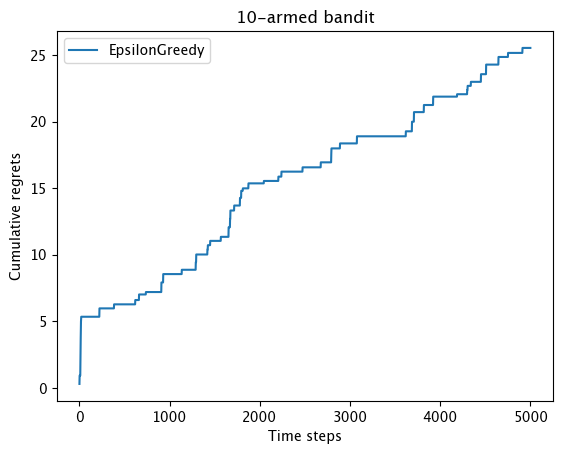

上置信界（UCB）算法
基于霍夫丁不等式：
$$
P \{ \mathbb{E} \left[ X \right] \geq \bar{x}_n + u \} \leq e^{-2nu^2}
$$
其中 $u = \hat{U}_t(a)$ 代表不确定性度量，给定一个概率 $p=e^{-2N_t(a)U_t(a)^2}$，则根据霍夫丁不等式，$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a)$ 至少以概率 $1-p$ 成立，当 $p$ 很小时，$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a)$以很大概率成立，$\hat{Q}_t(a) + \hat{U}_t(a)$ 即为期望奖励上界，此时 UCB 算法取期望奖励上界最大的动作，即：
$$a = \arg \max_{a \in A} \left[ \hat{Q}(a) + \hat{U}(a) \right]$$
根据 $p=e^{-2N_t(a)U_t(a)^2}$，解得 $\hat{U}_t(a) = \sqrt \frac {-\log p} {2N_t(a)}$

上置信界算法的累积懊悔为： 70.45281214197854


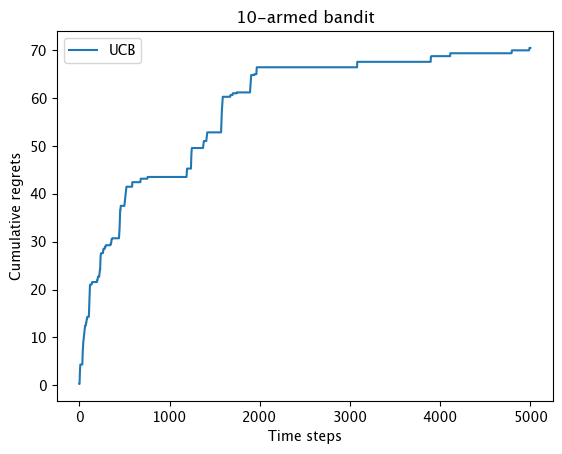

In [45]:
class UCB(Solver):
    """UCB算法，继承 Solver 类"""

    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef  # 控制不确定性的比重

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


np.random.seed(1)
coef = 1
UCB_solver = UCB(bandit_10_arm, coef, init_prob=1.0)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])


# MDP 马尔可夫决策过程
## 马尔可夫奖励过程
$<\mathcal{S, P}, r, \gamma>$
* $\mathcal S$ 是有限状态的集合。
* $\mathcal P$ 是状态转移矩阵。
* $r$ 是奖励函数，某个状态 $s$ 的奖励 $r(s)$ 指转移到该状态时可以获得奖励的期望。
* $\gamma$ 是折扣因子（discount factor），$\gamma$ 的取值范围为。引入折扣因子的理由为远期利益具有一定不确定性，有时我们更希望能够尽快获得一些奖励，所以我们需要对远期利益打一些折扣。接近 1 的 $\gamma$ 更关注长期的累计奖励，接近 0 的 $\gamma$ 更考虑短期奖励。

<center><img src="https://hrl.boyuai.com/static/mrp.c1e62649.png">

In [46]:
import numpy as np

np.random.seed(0)
# 定义状态转移概率矩阵P
P = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
P = np.array(P)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子


# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报
def compute_return(start_index, chain, gamma):
    G = 0
    for i in reversed(range(start_index, len(chain))):
        G = gamma * G + rewards[chain[i] - 1]
        print("当前状态为：%s, 奖励为：%s, 回报为：%s" % (chain[i], rewards[chain[i] - 1], G))
    return G


# 一个状态序列 s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print("根据本序列计算得到回报为：%s。" % G)

当前状态为：6, 奖励为：0, 回报为：0.0
当前状态为：3, 奖励为：-2, 回报为：-2.0
当前状态为：2, 奖励为：-2, 回报为：-3.0
当前状态为：1, 奖励为：-1, 回报为：-2.5
根据本序列计算得到回报为：-2.5。


### 价值函数
在马尔可夫奖励过程中，一个状态的期望回报（即从这个状态出发的未来累积奖励的期望）被称为这个状态的价值（value）。所有状态的价值就组成了价值函数（value function），价值函数的输入为某个状态，输出为这个状态的价值。我们将价值函数写成 $V(s)=\mathbb E \left [ G_t|S_t = s \right ]$，展开为：
$$
\begin{aligned}
V(s) &= \mathbb E [G_t|S_t = s]\\
     &= \mathbb E [R_t + \gamma R_{t+1} + \gamma^2R_{t+2} + \cdots |S_t=s]\\
     &= \mathbb E [R_t + \gamma (R_{t+1} + \gamma R_{t+2} + \cdots)|S_t = s]\\
     &= \mathbb E [R_t + \gamma G_{t+1}|S_t = s]\\
     &= \mathbb E [R_t + \gamma V(S_{t+1})|S_t = s]
\end{aligned}
$$

由于即时奖励的期望正是奖励函数的输出，$\mathbb E [R_t|S_t = s] = r(s)$
且
$$
\mathbb E [\gamma V(S_{t+1})|S_t = s] = \gamma \sum_{s' \in S} p(s'|s)V(s')
$$

这里将 $G_{t+1}$ 替换为 $V(S_{t+1})$ 后仍然在期望内的原因是：
$\mathbb E [\gamma G_{t+1}|S_t = s]$实际上是$\mathbb E [\gamma G_{t+1}|S_t = s, S_{t+1} = s']$
只要随机变量不是确定的，就要用期望来表示
$$
V(s) = r(s) + \gamma \sum_{s' \in S} p(s'|s)V(s')
$$

将所有状态的价值表示成一个列向量 $\mathcal V = [V(s_1), V(s_2), \dots, V(s_n)]^T$，同样将奖励函数写成列向量形式 $\mathcal R = [r(s_1), r(s_2), \dots , r(s_n)]^T$。可以将贝尔曼方程写成矩阵的形式：
$$
\mathcal V = \mathcal R + \gamma \mathcal{PV}
$$
于是可以求得解析解：
$$
\begin{aligned}
\mathcal V &= \mathcal R + \gamma \mathcal{PV}\\
(I - \gamma \mathcal P) \mathcal V &= \mathcal R\\
\mathcal V &= (I - \gamma \mathcal P)^{-1} \mathcal R
\end{aligned}
$$
以上解析解的计算复杂度是$O(n^3)$，其中$n$是状态个数，因此这种方法只适用很小的马尔可夫奖励过程。求解较大规模的马尔可夫奖励过程中的价值函数时，可以使用动态规划（dynamic programming）算法、蒙特卡洛方法（Monte-Carlo method）和时序差分（temporal difference）

In [47]:
def compute(P, rewards, gamma, states_num):
    """ 利用贝尔曼方程的矩阵形式计算解析解,states_num是MRP的状态数 """
    rewards = np.array(rewards).reshape((-1, 1))  #将rewards写成列向量形式
    value = np.dot(np.linalg.inv(np.eye(states_num, states_num) - gamma * P), rewards)
    return value


V = compute(P, rewards, gamma, 6)
print("MRP中每个状态价值分别为\n", V)

MRP中每个状态价值分别为
 [[-2.01950168]
 [-2.21451846]
 [ 1.16142785]
 [10.53809283]
 [ 3.58728554]
 [ 0.        ]]


## 马尔可夫决策过程
$<\mathcal{S, A}, P, r, \gamma>$
* $\mathcal S$ 是有限状态的集合。
* $\mathcal A$ 是动作的集合。
* $\gamma$ 是折扣因子。
* $r(s, a)$ 是奖励函数，此时奖励可以同时取决于状态$S$和动作$a$，在奖励函数只取决于状态$s$时，则退化为$r(s)$；
* $P(s'|s, a)$ 是状态转移函数，表示在状态$s$执行动作$a$之后到达状态$s'$的概率。

我们发现 MDP 与 MRP 非常相像，主要区别为 MDP 中的状态转移函数和奖励函数都比 MRP 多了动作$a$作为自变量。注意，在上面 MDP 的定义中，我们不再使用类似 MRP 定义中的状态转移矩阵方式，而是直接表示成了状态转移函数。这样做一是因为此时状态转移与动作也有关，变成了一个三维数组，而不再是一个矩阵（二维数组）；二是因为状态转移函数更具有一般意义，例如，如果状态集合不是有限的，就无法用数组表示，但仍然可以用状态转移函数表示。


### 策略
智能体的策略(Policy)用$\pi$表示，策略$\pi(a|s)=P(A_t=a|S_t=s)$是一个函数，表示在输入状态$s$情况下采取动作$a$的概率。
1. 状态价值函数

    用$V^{\pi}(s)$表示在 MDP 中基于策略$\pi$的状态价值函数(state-value function)，定义为从状态$s$出发，遵循策略$\pi$能获得的期望回报，数学表达为：
    $$
    V^{\pi}(s) = \mathbb E _{\pi} [G_t|S_t=s]
    $$
2. 动作价值函数

    在 MDP 中，由于动作的存在，我们额外定义一个动作价值函数（action-value function）
    $$
    Q^{\pi}(s, a)=\mathbb E_{\pi}[G_t|S_t=s,A_t=a]
    $$

状态价值函数和动作价值函数间的关系：在使用策略$\pi$中，状态$s$的价值等于在该状态下基于策略$\pi$采取所有动作的概率与相应的价值相乘再求和的结果：
$$
V^{\pi}(s) = \sum_{a' \in \mathcal A} \pi(a|s) Q^{\pi}(s, a)
$$

### 贝尔曼期望方程
#### 状态价值函数的贝尔曼期望方程
$$
\begin{aligned}
V^{\pi}(s) &= \mathbb E _{\pi}[G_t|S_t = s]\\
        &= \mathbb E_{\pi} [R_t + \gamma V^{\pi}(S_{t+1})|S_t = s]\\
        &= \sum _{a \in \mathcal A} \pi(a|s)r(s, a) +
        \gamma
        \sum_{a \in \mathcal A} \pi(a|s)
        \sum_{s' \in \mathcal S} p(s'|s, a) V^{\pi}(s')\\
        &= \sum _{a \in \mathcal A} \pi(a|s) \left ( r(s, a) + \gamma \sum_{s' \in \mathcal S}p(s'|s, a)V^{\pi}(s') \right )
\end{aligned}
$$
#### 动作价值函数的贝尔曼期望方程
$$
\begin{aligned}
Q^{\pi}(s, a) &= \mathbb E _{\pi}[G_t|S_t = s, A_t = a]\\
        &= \mathbb E_{\pi} [R_t + \gamma V^{\pi}(S_{t+1})|S_t = s, A_t = a]\\
        &= r(s, a) + \gamma \sum_{s' \in \mathcal A} p(s'|s, a) V^{\pi}(s')\\
        &= r(s, a) + \gamma \sum_{s' \in \mathcal S} p(s'|s, a) \sum _{a' \in \mathcal A}
           \pi(a'|s') Q^{\pi}(s', a')
\end{aligned}
$$
其中 $V^{\pi}(s') = \sum _{a' \in \mathcal A} \pi(a'|s') Q^{\pi}(s', a')$

## 蒙特卡洛方法
$$
V^{\pi}(s) = \mathbb E _{\pi} [G_t|S_t = s] \approx \frac 1 N \sum _{i=1} ^{N} G_t^{(i)}
$$
<center><image src = 'https://hrl.boyuai.com/static/mdp.aaacb46a.png'>

In [48]:
S = ["s1", "s2", "s3", "s4", "s5"]  # 状态集合
A = ["保持s1", "前往s1", "前往s2", "前往s3", "前往s4", "前往s5", "概率前往"]  # 动作集合
# 状态转移函数
P = {
    "s1-保持s1-s1": 1.0,
    "s1-前往s2-s2": 1.0,
    "s2-前往s1-s1": 1.0,
    "s2-前往s3-s3": 1.0,
    "s3-前往s4-s4": 1.0,
    "s3-前往s5-s5": 1.0,
    "s4-前往s5-s5": 1.0,
    "s4-概率前往-s2": 0.2,
    "s4-概率前往-s3": 0.4,
    "s4-概率前往-s4": 0.4,
}
# 奖励函数
R = {
    "s1-保持s1": -1,
    "s1-前往s2": 0,
    "s2-前往s1": -1,
    "s2-前往s3": -2,
    "s3-前往s4": -2,
    "s3-前往s5": 0,
    "s4-前往s5": 10,
    "s4-概率前往": 1,
}
gamma = 0.5  # 折扣因子
MDP = (S, A, P, R, gamma)

# 策略1,随机策略
Pi_1 = {
    "s1-保持s1": 0.5,
    "s1-前往s2": 0.5,
    "s2-前往s1": 0.5,
    "s2-前往s3": 0.5,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.5,
    "s4-概率前往": 0.5,
}
# 策略2
Pi_2 = {
    "s1-保持s1": 0.6,
    "s1-前往s2": 0.4,
    "s2-前往s1": 0.3,
    "s2-前往s3": 0.7,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.1,
    "s4-概率前往": 0.9,
}


# 把输入的两个字符串通过“-”连接,便于使用上述定义的P、R变量
def join(str1, str2):
    return str1 + '-' + str2

gamma = 0.5
# 转化后的MRP的状态转移矩阵
P_from_mdp_to_mrp = [
    [0.5, 0.5, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.5],
    [0.0, 0.1, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.0, 0.0, 1.0],
]
P_from_mdp_to_mrp = np.array(P_from_mdp_to_mrp)
R_from_mdp_to_mrp = [-0.5, -1.5, -1.0, 5.5, 0]

V = compute(P_from_mdp_to_mrp, R_from_mdp_to_mrp, gamma, 5)
print("MDP中每个状态价值分别为\n", V)

MDP中每个状态价值分别为
 [[-1.22555411]
 [-1.67666232]
 [ 0.51890482]
 [ 6.0756193 ]
 [ 0.        ]]


定义一个采样函数。采样函数需要遵守状态转移矩阵和相应的策略，每次将(s,a,r,s_next)元组放入序列中，直到到达终止序列。然后我们通过该函数，用随机策略在图 3-4 的 MDP 中随机采样几条序列。

In [49]:
import numpy as np

def sample(MDP, Pi:dict, timestep_max, number):
    S, A, P, R, gamma = MDP
    episodes = []
    for _ in range(number):
        episode = []
        timestep = 0
        s = S[np.random.randint(4)] # 随机选择一个除 s5 以外的状态 s 作为起点
        # 当前状态为终值状态或者时间步太长时，一次采样结束
        while s != "s5" and timestep <= timestep_max:
            timestep += 1
            rand, temp = np.random.rand(), 0
            # 在状态 s 下根据策略选择动作
            for a_opt in A:
                temp += Pi.get(join(s, a_opt), 0)
                if temp > rand:
                    a = a_opt
                    r = R.get(join(s, a), 0)
                    break
            rand, temp = np.random.rand(), 0
            for s_opt in S:
                temp += P.get(join(join(s, a), s_opt), 0)
                if temp > rand:
                    s_next = s_opt
                    break
            episode.append((s, a, r, s_next))
            s = s_next
        episodes.append(episode)
    return episodes

# 采样 5 次，每个序列最长不超过 20 步
episodes = sample(MDP, Pi_1, 20, 5)
print('第一条序列\n', episodes[0])
print('第二条序列\n', episodes[1])
print('第五条序列\n', episodes[4])

第一条序列
 [('s1', '前往s2', 0, 's2'), ('s2', '前往s3', -2, 's3'), ('s3', '前往s5', 0, 's5')]
第二条序列
 [('s4', '概率前往', 1, 's4'), ('s4', '前往s5', 10, 's5')]
第五条序列
 [('s2', '前往s3', -2, 's3'), ('s3', '前往s4', -2, 's4'), ('s4', '前往s5', 10, 's5')]


In [50]:
# 对所有采样序列计算所有状态的价值
def MC(episodes, V, N, gamma):
    for episode in episodes:
        G = 0
        for i in range(len(episode) - 1, -1, -1):
            (s, a, r, s_next) = episode[i]
            G = r + gamma * G
            N[s] += 1
            V[s] += (G - V[s]) / N[s]

timestep_max = 20
# 采样 1000 次
episodes = sample(MDP, Pi_1, timestep_max, 1000)
gamma = 0.5
V = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
N = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
MC(episodes, V, N, gamma)
print("使用蒙特卡洛方法计算MDP的状态价值为\n", V)

使用蒙特卡洛方法计算MDP的状态价值为
 {'s1': -1.228923788722258, 's2': -1.6955696284402704, 's3': 0.4823809701532294, 's4': 5.967514743019431, 's5': 0}


可以看到用蒙特卡洛方法估计得到的状态价值和我们用 MRP 解析解得到的状态价值是很接近的。这得益于我们采样了比较多的序列

## 贝尔曼最优方程
$$
V^*(s) = \max_{a \in \mathcal{A}} \left\{ r(s, a) +
         \gamma \sum_{s' \in \mathcal{S}} p(s'|s, a)V^*(s') \right\}
$$
$$
Q^*(s, a) = r(s, a) + \gamma \sum_{s' \in \mathcal S} p(s'|s, a)\max_{a' \in \mathcal A} Q^*(s', a')
$$
其中最优状态价值是选择此时使最优动作价值最大的那一个动作时的状态价值：
$$
V^*(s) = \max_{a \in \mathcal A} Q^*(s, a)
$$

# DQN

In [20]:
import random
import gym
import numpy as np
import collections
from tqdm import  tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

class ReplayBuffer:
    """
    经验回放池
    """
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # 队列，先进先出
        
    def add(self, state, action, reward, next_state, done): # 将数据加入 buffer 中
        self.buffer.append(
            (state, action, reward, next_state, done)
        )
        
    def sample(self, batch_size): # 从 buffer 中采样数据，数量为 batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self): # 目前 buffer 中数据的数量
        return len(self.buffer)
    
class Qnet(torch.nn.Module):
    """只有一层隐藏层的 Q 网络"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# DQN 算法
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [22]:
lr = 2e-3
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='human')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset(seed=0)[0]
            done = False
            steps = 0
            while not done and steps < 200:
                steps += 1
                action = agent.take_action(state)
                next_state, reward, done, _, __ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 764.86it/s, episode=50,
# return=9.300]
# Iteration 1: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s, episode=100,
# return=12.300]
# Iteration 2: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, episode=150,
# return=123.000]
# Iteration 3: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it, episode=200,
# return=153.600]
# Iteration 4: 100%|██████████| 50/50 [01:30<00:00,  1.80s/it, episode=250,
# return=180.500]
# Iteration 5: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it, episode=300,
# return=185.000]
# Iteration 6: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, episode=350,
# return=193.900]
# Iteration 7: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=400,
# return=196.600]
# Iteration 8: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, episode=450,
# return=193.800]
# Iteration 9: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, episode=500,
# return=200.000]

Iteration 9: 100%|██████████| 20/20 [01:24<00:00,  4.21s/it, episode=200, return=200.000]


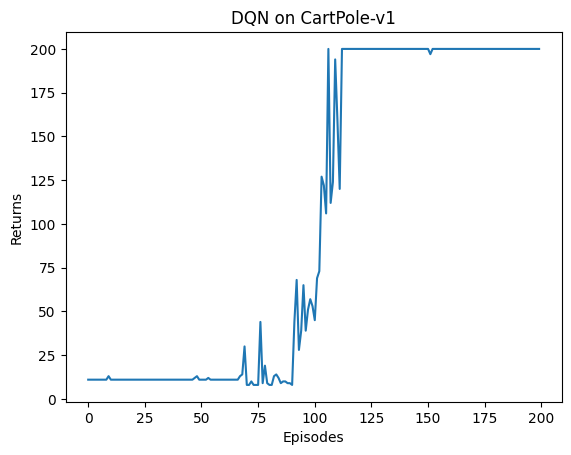

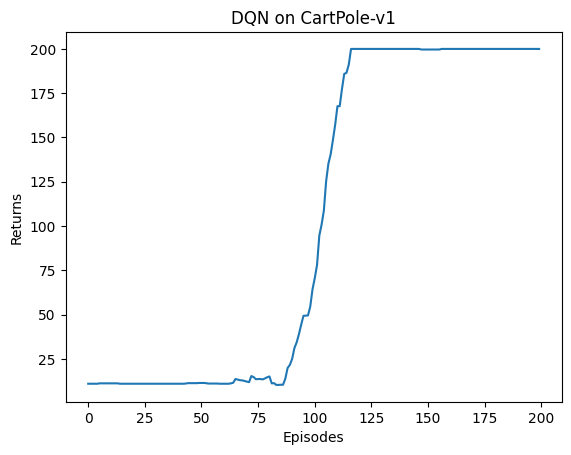

In [23]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

# 策略梯度算法


## REINFORCE(on-policy)

In [40]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

# 先定义策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# 定义 REINFORCE 算法类
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.device = device

    def take_action(self, state): # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self,transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))): # 从最后一步开始计算 Return（常用的 trick）
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_probs = torch.log(self.policy_net(state)).gather(1, action)
            G = self.gamma * G + reward
            loss = - G * log_probs
            loss.backward()
        self.optimizer.step()

learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset(seed=0)[0]
            done = False
            # step = 0
            # while not done and step < 200:
            while not done:
                # step += 1
                action = agent.take_action(state)
                next_state, reward, done, _, __ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s, episode=1000, return=1289.400]


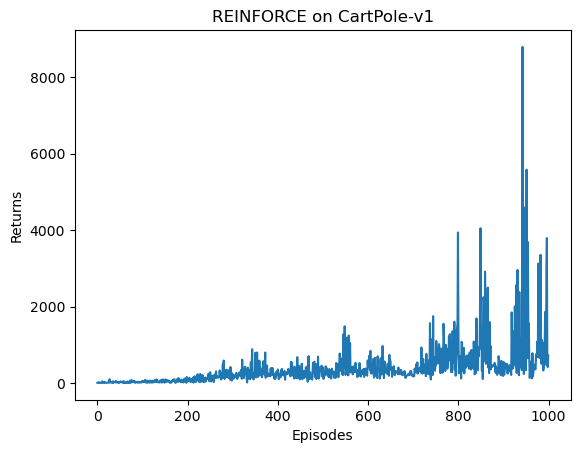

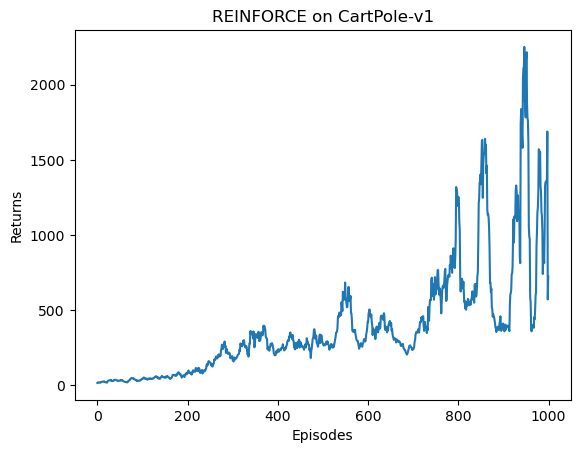

In [41]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

## 经验回放


经验回放作为一种 off-policy 的 trick，而 policy gradient 作为 on-policy 的方法，需要用 importance sampling 去克服 behavior policy 和 target policy 之间的分布差异
$$
\begin{aligned}
\mathbb E_{x \sim p_0} [X] &= \sum_{x \in \mathcal X} x P(x) \\
                      &= \sum_{x \in \mathcal X} \frac x {P(x')} P(x') P(x) \\
                      &= \sum_{x' \in \mathcal X'} \left [ \frac {P(x)} {P(x')} x \right ] P(x') \\
                      &= \mathbb E_{x \sim p_1} [f(X)]
\end{aligned}
$$

$$
\begin{aligned}
\mathbb E_{A \sim \beta} \left [ v_{\pi_{\beta}}(s) \right ] &=
\sum _{A \sim \pi_{\beta}} \pi_{\beta}(a|s) \sum_{S' \in \mathcal S}
p(s'|s, a)v(s')
\end{aligned}
$$

## AC with Reply

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/var/folders/x5/0xv_d_m50hl4ks2_hr1pwggw0000gn/T/ipykernel_34858/858260883.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1739474914747/work/torch/csrc/utils/tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
/Users/mei/anaconda3/envs/Hands_on_RL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 100/100 [00:11<00:00,  8.84it/s, episode=1000, return=74.8, eval_return=69.3]


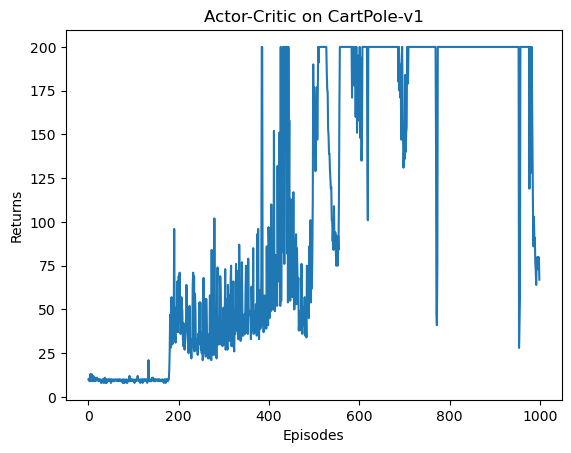

In [3]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections
import random

# 经验回放池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done, behavior_prob):
        self.buffer.append((state, action, reward, next_state, done, behavior_prob))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, behavior_prob = zip(*transitions)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done), np.array(behavior_prob)

    def size(self):
        return len(self.buffer)

# 策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Actor_Critic:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.value_net = ValueNet(state_dim, hidden_dim).to(device)
        self.optimizer_policy = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.optimizer_value = torch.optim.Adam(self.value_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.device = device

    def take_action(self, state, epsilon=0.1):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)

        # 计算epsilon-greedy策略
        if random.random() < epsilon:
            action = random.randint(0, probs.shape[1]-1)
            behavior_prob = epsilon / probs.shape[1] + (1-epsilon)*probs[0, action].item()
        else:
            action = torch.argmax(probs).item()
            behavior_prob = (1-epsilon) + epsilon / probs.shape[1]

        return action, behavior_prob

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        old_probs = torch.tensor(transition_dict['behavior_probs'], dtype=torch.float).view(-1, 1).to(self.device)

        # 价值函数更新
        td_target = rewards + self.gamma * self.value_net(next_states) * (1 - dones)
        td_delta = td_target - self.value_net(states)
        value_loss = F.mse_loss(self.value_net(states), td_target.detach())

        self.optimizer_value.zero_grad()
        value_loss.backward()
        self.optimizer_value.step()

        # 策略网络更新
        probs = self.policy_net(states).gather(1, actions)
        ratio = probs / old_probs
        advantage = td_delta.detach()
        policy_loss = -torch.mean(ratio * advantage)

        self.optimizer_policy.zero_grad()
        policy_loss.backward()
        self.optimizer_policy.step()

    def evaluate(self, env, num_episodes=10):
        total_return = 0
        for _ in range(num_episodes):
            state = env.reset()[0]
            done = False
            episode_return = 0
            step = 0
            while not done and step < 200:
                step += 1
                with torch.no_grad():
                    state_tensor = torch.tensor([state], dtype=torch.float).to(self.device)
                    probs = self.policy_net(state_tensor)
                    action = torch.argmax(probs).item()
                next_state, reward, done, _, _ = env.step(action)
                state = next_state
                episode_return += reward
            total_return += episode_return
        return total_return / num_episodes

# 超参数设置
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
buffer_size = 10000
minimal_size = 128
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 环境初始化
env = gym.make('CartPole-v1')
replay_buffer = ReplayBuffer(buffer_size)
agent = Actor_Critic(
    state_dim=env.observation_space.shape[0],
    hidden_dim=hidden_dim,
    action_dim=env.action_space.n,
    learning_rate=learning_rate,
    gamma=gamma,
    device=device
)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc=f'Iteration {i}') as pbar:
        for _ in range(int(num_episodes/10)):
            episode_return = 0
            state = env.reset()[0]
            done = False

            step = 0
            # 收集轨迹数据
            while not done and step < 200:
                step += 1
                action, behavior_prob = agent.take_action(state, epsilon)
                next_state, reward, done, _, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done, behavior_prob)
                state = next_state
                episode_return += reward

                # 当缓冲区足够大时开始更新
                if replay_buffer.size() >= minimal_size:
                    # 从缓冲区采样
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, batch_probs = replay_buffer.sample(batch_size)

                    transition_dict = {
                        'states': batch_states,
                        'actions': batch_actions,
                        'rewards': batch_rewards,
                        'next_states': batch_next_states,
                        'dones': batch_dones,
                        'behavior_probs': batch_probs
                    }

                    agent.update(transition_dict)

            return_list.append(episode_return)

            # 评估策略
            if (len(return_list) % 100) == 0:
                avg_return = agent.evaluate(env)
                pbar.set_postfix({
                    'episode': len(return_list),
                    'return': np.mean(return_list[-10:]),
                    'eval_return': avg_return
                })

            pbar.update(1)

# 训练结果可视化
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on CartPole-v1')
plt.show()

## 正确的 Actor Critic 算法

In [4]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import  rl_utils

class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim, action_dim).to(device)

        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float).to(self.device).unsqueeze(0)
        probs = self.actor(state_tensor)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions'])).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)

        # TD target 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        # TD error 时序差分误差
        td_delta = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach()) # 通过.detach()将td_delta视为固定权重，确保Actor仅通过策略梯度更新，严格遵循策略梯度定理。

        # 均方误差损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:01<00:00, 70.80it/s, episode=1000, return=200.000]


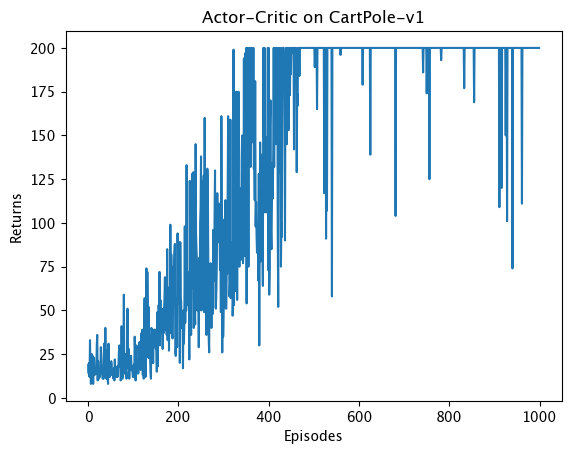

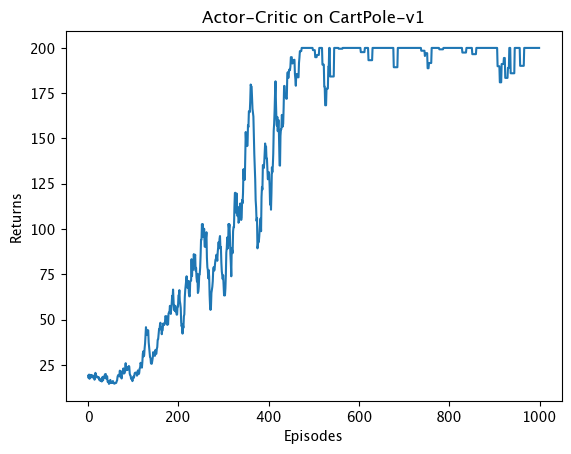

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

## PPO 近端策略优化
要点：
1. 重要性采样
2. clip 剪切梯度，防止过度更新

Iteration 9: 100%|██████████| 100/100 [00:02<00:00, 45.81it/s, episode=1000, return=200.000]


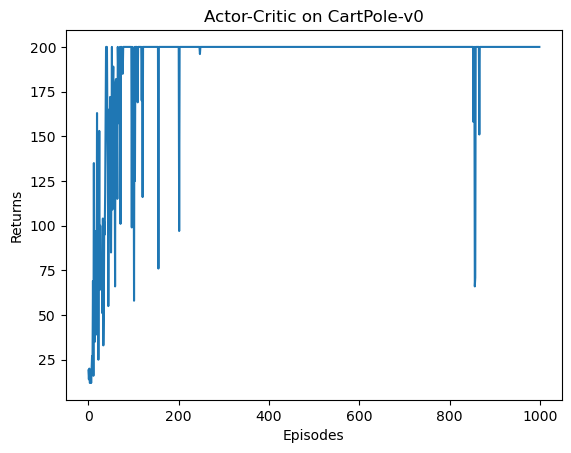

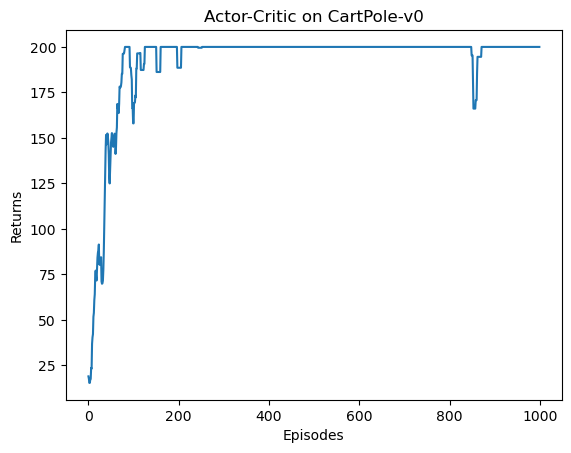

In [9]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import rl_utils

class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PPO:
    """PPO算法， 采用截断方式"""
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs # 一条序列的数据用来训练的轮数
        self.eps = eps # PPO 中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device) # 将 标量 state 包装成二维 list,输出的 state 张量的维度是 (batch = 1, dim = 4)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs) # 根据 probs 来创建分类分布
        """
        输入参数 probs
        probs 是一个形状为 (N, K) 的张量，其中：
        - N 是批量大小（batch size）。
        - K 是类别的数量。
        - probs 的每个元素表示对应类别的概率，且每一行的概率之和必须为 1（即 torch.sum(probs, dim=-1) == 1）。
          如果 probs 未归一化（即概率之和不等于 1），PyTorch 会自动对其进行归一化。
        """
        action = action_dist.sample()
        return action.item() # action 是 tensor 类型

    def compute_advantage(self, gamma, lmbda, td_delta):
        td_delta = td_delta.detach().numpy()
        # 如果张量在 GPU 上，需要先将其移动到 CPU 上才能调用 .numpy()
        # td_delta_numpy = td_delta.cpu().detach().numpy()
        # 这里截断梯度的原因是目标函数的梯度中不包含优势函数 A
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = gamma * lmbda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float)

    def update(self, transition_dict): # transition_dict 中存储了 batch, dim 维度的轨迹张量
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions'])).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device) # view 函数将 actions 的 shape 调整为 (batch, 1)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)
        
        td_targets = rewards + self.gamma * (1 - dones) * self.critic(next_states)
        td_error = td_targets - self.critic(states)
        
        # 计算优势函数
        advantage = self.compute_advantage(self.gamma, self.lmbda, td_error.cpu()).to(self.device)
        
        # 重要性采样(这里取对数表示，便于计算)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_targets.detach())) # td_targets 中有 critic 网络的梯度, 不固定 td_targets 会导致梯度反向传播路径冲突
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent_with_step_limit(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

## GAE 广义优势估计

In [4]:
import torch

# 假设 td_delta 是一个需要梯度的张量
td_delta = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# 计算 GAE
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

gamma = 0.9
lmbda = 0.8
gae = compute_advantage(gamma, lmbda, td_delta)


## SAC

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/Users/mei/anaconda3/envs/Hands_on_RL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s, episode=100, return=-126.977]


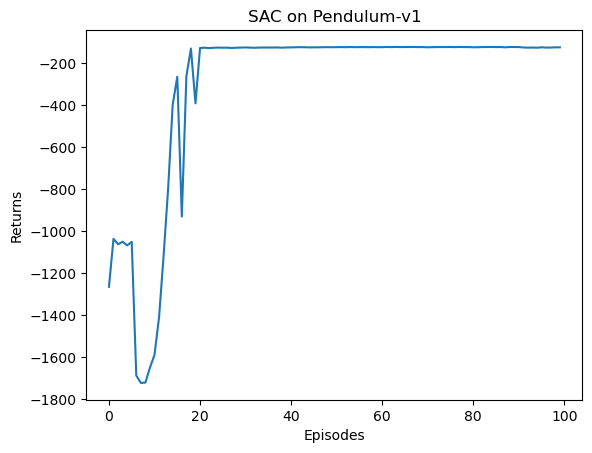

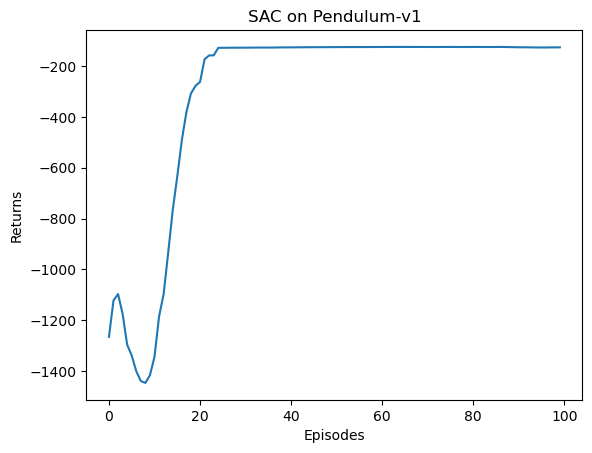

In [5]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        # 连续控制任务输出 π(a|s) 分布的均值和方差
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample() # 重采样保持梯度连续
        log_prob = dist.log_prob(normal_sample)
        # 将动作空间压缩到 [-1, 1]
        action = torch.tanh(normal_sample) 
        """
        多维空间的压缩方法: 对每一维分别进行压缩, 如下:
        log π(a|s) = log p(u|s) - log(1 - tanh(u)^2)
                   = \sum_i^d [log p(u_i|s) - log(1 - a_i^2)]
        其中 a = tanh(u), p(u|s) 是 u 的概率密度函数, d 为动作空间的维度
        """
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob
    
class QValueNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim) # Q(s_t, a_t)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)
        
    def forward(self, state, action):
        cat = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)
    
class SACContinuous:
    """处理连续动作的 SAC 算法"""
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic_1 = QValueNet(state_dim, action_dim, hidden_dim).to(device)
        self.critic_2 = QValueNet(state_dim, action_dim, hidden_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, action_dim, hidden_dim).to(device)
        self.target_critic_2 = QValueNet(state_dim, action_dim, hidden_dim).to(device)
        
        # 令目标 Q 网络的初始参数和 Q 网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        # 定义所有价值网络和策略网络的优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        # 自适应熵温度系数需要对 alpha 求导
        self.log_alpha.requires_grad = True # 可以对 alpha 求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        
        self.target_entropy = target_entropy # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device
        
    def take_action(self, state):
        state = torch.tensor(np.array(state), dtype=torch.float).to(device)
        action = self.actor(state)[0] # actor 返回 action 和 log_prob(π)
        return [action.item()] # 维度为 (batch=1, action_dim)
    
    # 计算目标 Q 值
    def calculate_target_Q(self, rewards, next_states, dones):
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob # 定义熵 -log(π(a|s))
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy # 增加了熵正则项的 Q_soft
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target
    
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + 
                                    param.data * self.tau)
            
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(device)
        # 对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0
        
        # 更新两个网络
        td_target = self.calculate_target_Q(rewards, next_states, dones)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()
        
        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(
            -self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value)
        )
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 自适应熵温度系数, 更新 alpha 值
        alpha_loss = torch.mean(
            self.log_alpha.exp() * (entropy - self.target_entropy).detach() # entropy 依赖于 actor 计算出, 如果不 detach, 会出现计算图丢失报错
        )
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)
        
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0] # 动作最大值: tanh -> [-1, 1] * max_val

np.random.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = rl_utils.train_off_policy_agent_with_step_limit(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)
        
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()
        
        
        